In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent.


We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.

> Since our data has multiple features we are going to use multivariate or dependent multi-series forecasting methods

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# clean_METData = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_METData.csv')
data = clean_METData[['date','T2M_RANGE','T2M_MIN','WS10M_MAX','PRECTOTCORR','SPI']]
data.head()

,date,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
0,1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1,1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
2,1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
3,1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
4,1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01 '
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1991-01-29 00:00:00 --- 2019-12-31 00:00:00   (n=1510)
Test dates  : 2020-01-07 00:00:00 --- 2023-03-28 00:00:00   (n=169)


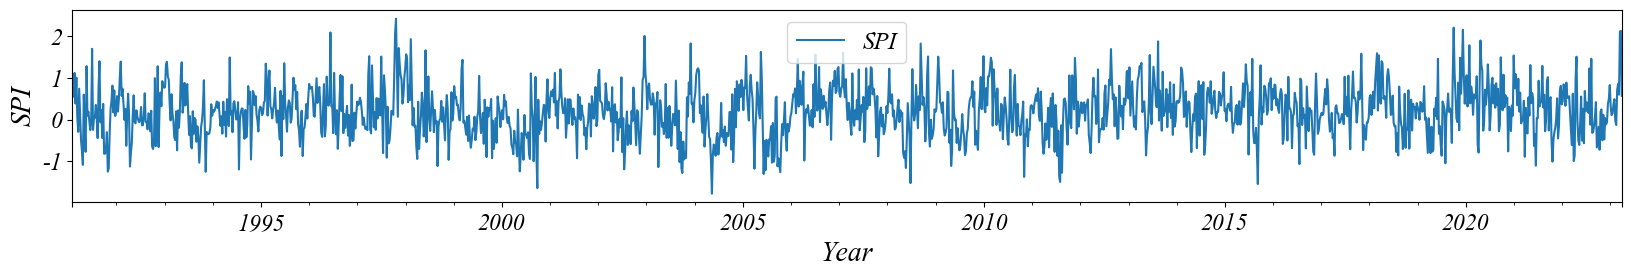

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
rdata['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2 )
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17)

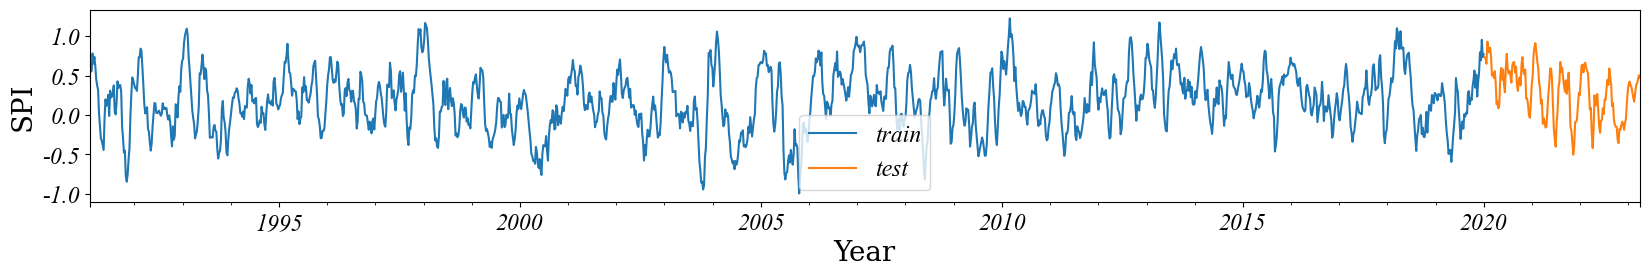

In [ ]:
# Plot
# ==============================================================================
#define font family to use for all text
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['font.family'] = 'Times New Roman'

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.rcParams['axes.unicode_minus'] = False
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

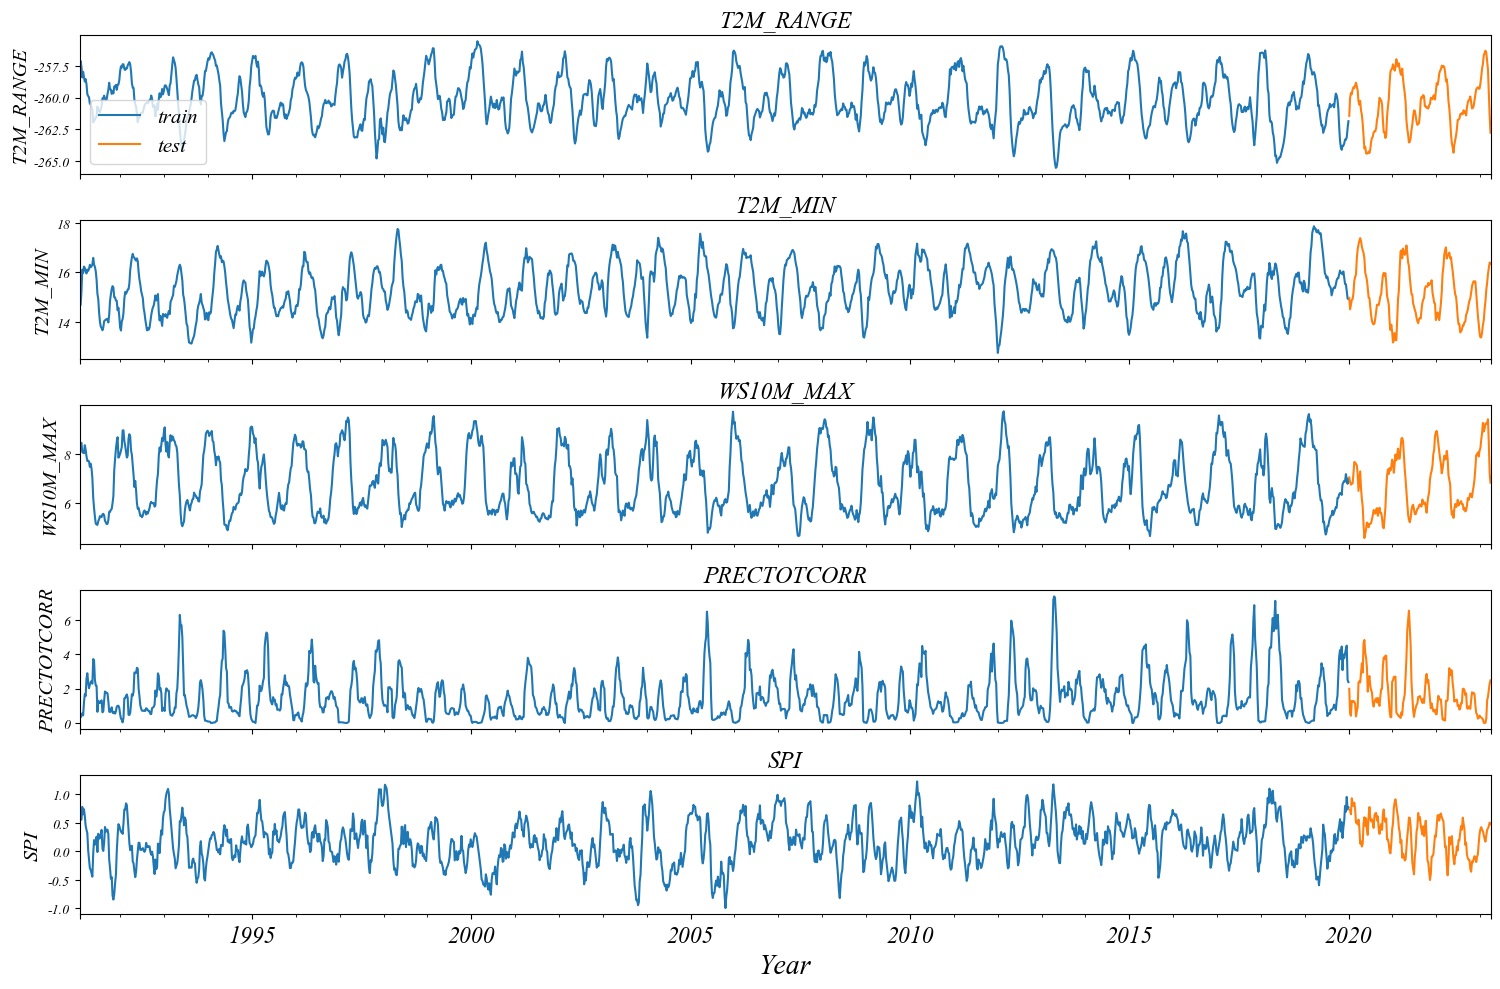

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10), sharex=True)
font2 = {'family':'serif','color':'black','size':20}

data_train['T2M_RANGE'].plot(label='train', ax=axes[0])
data_test['T2M_RANGE'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('Year',fontdict = font2)
axes[0].set_ylabel('T2M_RANGE',fontsize=15)
axes[0].set_title('T2M_RANGE',fontsize=17)
axes[0].legend(fontsize=15)

data_train['T2M_MIN'].plot(label='train', ax=axes[1])
data_test['T2M_MIN'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('Year',fontdict = font2)
axes[1].set_ylabel('T2M_MIN',fontsize=15)
axes[1].set_title('T2M_MIN',fontsize=17)

data_train['WS10M_MAX'].plot(label='train', ax=axes[2])
data_test['WS10M_MAX'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('Year',fontdict = font2)
axes[2].set_ylabel('WS10M_MAX',fontsize=15)
axes[2].set_title('WS10M_MAX',fontsize=17)

data_train['PRECTOTCORR'].plot(label='train', ax=axes[3])
data_test['PRECTOTCORR'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('Year',fontdict = font2)
axes[3].set_ylabel('PRECTOTCORR', fontsize=15)
axes[3].set_title('PRECTOTCORR',fontsize=17)

data_train['SPI'].plot(label='train', ax=axes[4])
data_test['SPI'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('Year',fontdict = font2)
axes[4].set_ylabel('SPI',fontsize=15)
axes[4].set_title('SPI',fontsize=17)
plt.xticks(fontsize=17)
fig.tight_layout()
plt.show();

### Dependent multi-series forecasting (Multivariate forecasting)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

#### RF

> Multiseries Single-Step

> In independent multi-series forecasting a single model is trained for all time series, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values.

In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(),
                 lags               = 4,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10, 50, 100, 200]
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth': [5, 10, 15]
}
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

36 models compared for 5 level(s). Number of iterations: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
26,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 200}",0.233614,15,200
35,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 200}",0.233968,15,200
21,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",0.234299,10,50
31,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.234701,10,100
12,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",0.234780,10,50
32,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 200}",0.235159,10,200
23,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 200}",0.235391,10,200
33,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 50}",0.235438,15,50
14,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 200}",0.235567,10,200
34,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 100}",0.235635,15,100


In [ ]:
print(results.lags[26])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(max_depth= 15, n_estimators=200),
                 lags               = 100,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data)

In [ ]:
# Backtesting Multi Series
# ==============================================================================
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = levels,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/169 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,T2M_RANGE,0.334654,0.178307,0.001284
1,T2M_MIN,0.158650,0.042248,0.010597
2,WS10M_MAX,0.207889,0.067834,0.031140
3,PRECTOTCORR,0.353545,0.247719,0.527176
4,SPI,0.110526,0.019641,1.399994



Backtest predictions


,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2020-01-07,-261.366786,14.934653,7.220776,1.713199,0.733982
2020-01-14,-260.795273,15.091943,7.315255,1.554580,0.708509
2020-01-21,-259.455391,14.503424,7.088348,0.256774,0.688121
2020-01-28,-258.994824,14.761784,7.032388,0.264775,0.673835


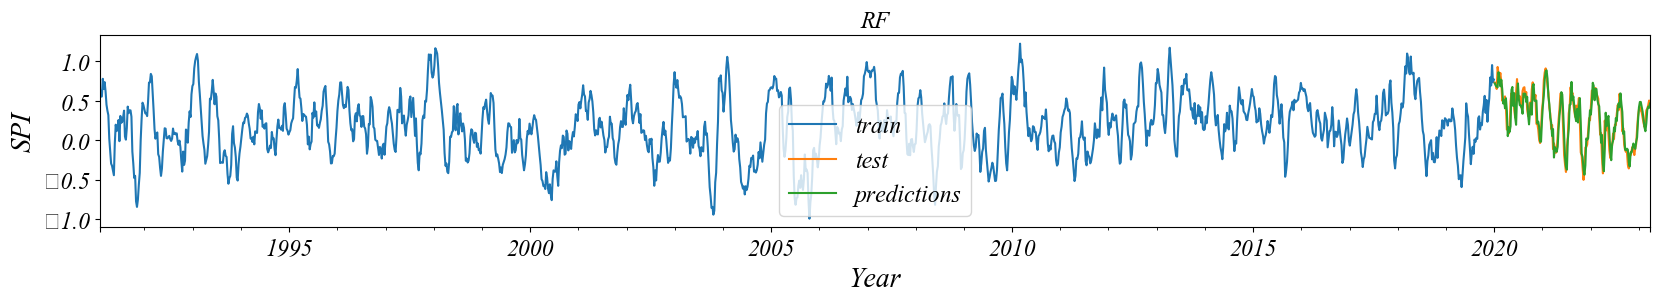

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

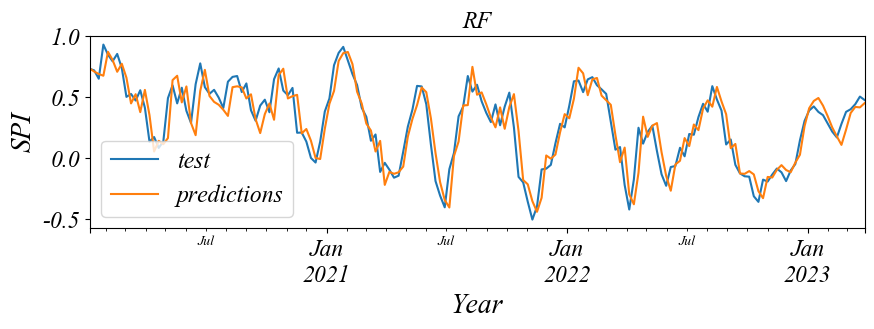

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2.5))
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
# SPI
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions['SPI'])
mse = mean_squared_error(data_test['SPI'],backtest_predictions['SPI'])
r2 = r2_score(data_test['SPI'],backtest_predictions['SPI'])
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions['SPI']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.11117171638173873
MSE is 0.019467602468405558
RMSE is 0.13952635044465816
R2 is 0.8116705173991767


In [ ]:
#T2M_RANGE
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
mse = mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
r2 = r2_score(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.33321953685409633
MSE is 0.17491493555058207
RMSE is 0.41822832944527094
R2 is 0.9569343763625267


In [ ]:
#T2M_MIN
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
mse = mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
r2 = r2_score(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.15931230464515192
MSE is 0.044075649405727696
RMSE is 0.20994201438903956
R2 is 0.9609679096421782


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
mse = mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
r2 = r2_score(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
rmse = math.sqrt(mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.20893205606748
MSE is 0.06866899413215916
RMSE is 0.26204769438436043
R2 is 0.9497149566673877


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
mse = mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
r2 = r2_score(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
rmse = math.sqrt(mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.355561568813115
MSE is 0.24989644286549167
RMSE is 0.4998964321391899
R2 is 0.8308294002337229


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.2336394365523164
MSE is 0.11140472488447321
RMSE is 0.33377346342163455
R2 is 0.9020234320609983


In [ ]:
forecaster.fit(data)
forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(max_depth=15, n_estimators=200) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Window size: 100 
Series levels (names): ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-01-29 00:00:00'), Timestamp('2023-03-28 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 7D 
Regressor paramet

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=300)
predictions.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2023-04-04,-263.259552,16.398712,6.431103,2.704950,0.413981
2023-04-11,-263.394893,16.402792,5.999426,3.102114,0.361716
2023-04-18,-263.526765,16.407254,5.712365,3.216181,0.292325
2023-04-25,-263.496883,16.328732,5.573686,3.161168,0.214577
2023-05-02,-263.408368,16.218136,5.598320,3.053537,0.121642


In [ ]:
predictions.tail(3)

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2028-12-12,-259.151744,14.816588,7.124657,0.306350,-0.125285
2028-12-19,-258.650827,14.828901,7.405024,0.308772,-0.121052
2028-12-26,-258.282308,14.838694,7.662081,0.308566,-0.115155


Text(0, 0.5, 'SPI')

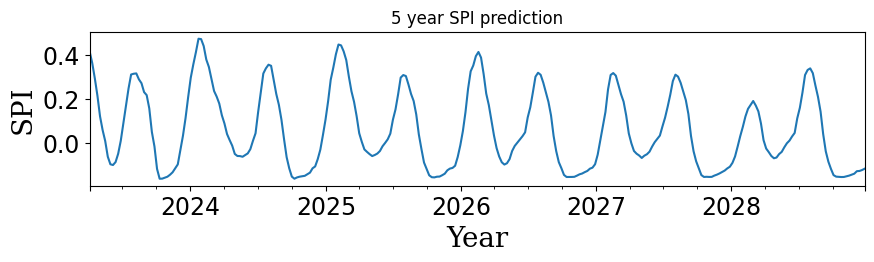

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
predictions['SPI'].plot(ax=ax,title='5 year SPI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)

> multi-step

In [ ]:
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor = RandomForestRegressor(random_state=123),
                 level              = 'SPI',
                 lags               = 100,
                 steps              = 53,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

# Lags used as predictors
lags_grid = [100, 200, 300]
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

results_grid = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              steps               = 53,
              metric              = ['mean_absolute_error', 'mean_squared_error'],
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = False,
              return_best         = True,
              verbose             = False
               )

18 models compared for 1 level(s). Number of iterations: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(results_grid.lags[0])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [ ]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = RandomForestRegressor(max_depth= 15, n_estimators= 50),
                 level              = 'SPI',
                 lags               = 100,
                 steps              = 1,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: RandomForestRegressor(max_depth=15, n_estimators=50) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 100 
Target series, level: SPI 
Multivariate series (names): ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI'] 
Maximum steps predicted: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-01-29 00:00:00'), Timestamp('2019-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training

In [ ]:

# Backtesting MultiVariate
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = False,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/169 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,SPI,0.122544,0.021769,1.118705



Backtest predictions


,SPI
2020-01-07,0.770555
2020-01-14,0.736225
2020-01-21,0.704564
2020-01-28,0.634049


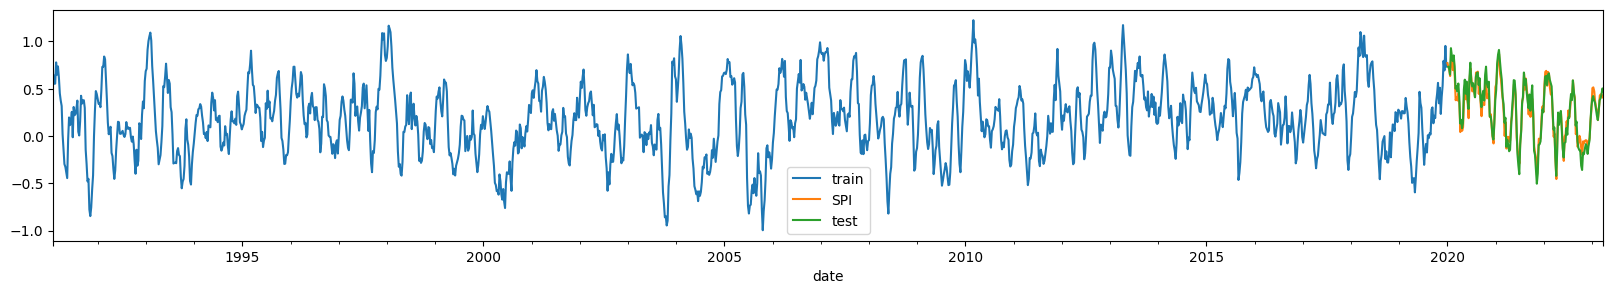

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_train['SPI'].plot(ax=ax, label='train')
backtest_predictions.plot(ax=ax, label='predicted')
data_test['SPI'].plot(ax=ax, label='test')
ax.legend();

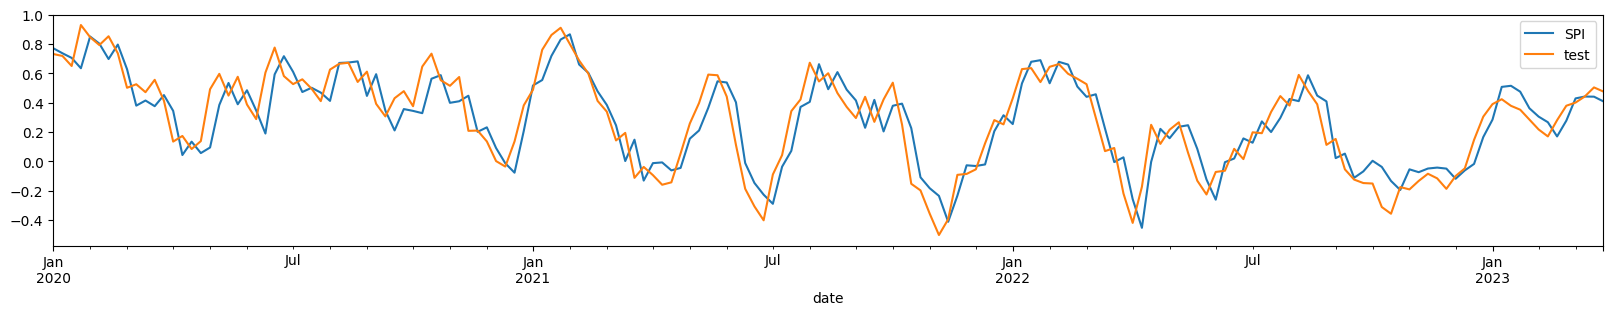

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
backtest_predictions.plot(ax=ax, label='predicted')
data_test['SPI'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions)
mse = mean_squared_error(data_test['SPI'],backtest_predictions)
r2 = r2_score(data_test['SPI'],backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.12254437596329293
MSE is 0.021769208125431684
RMSE is 0.14754391931025718
R2 is 0.789404796530758


In [ ]:
forecaster.fit(data)
forecaster

ForecasterAutoregMultiVariate 
Regressor: RandomForestRegressor(max_depth=15, n_estimators=50) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 100 
Target series, level: SPI 
Multivariate series (names): ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI'] 
Maximum steps predicted: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-01-29 00:00:00'), Timestamp('2023-03-28 00:00:00')] 
Training index type: DatetimeIndex 
Training

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
predictions.head(3)

,SPI
2023-04-04,0.326621
